# Kaggle猫狗大战图像二分类

同济子豪兄

2022-7-16

Kaggle 猫狗大战数据集：https://www.kaggle.com/tongpython/cat-and-dog

## 进入 mmclassification 目录

In [1]:
import os
os.chdir('mmclassification')

## 导入工具包

In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)

device cuda:0


In [5]:

# import mmcv

# from PIL import Image

# from mmcls.apis import inference_model, init_model, show_result_pyplot

## 下载数据集

In [11]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/cats_dogs_dataset.zip -O data/cats_dogs_dataset.zip

--2022-07-16 19:29:03--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/cats_dogs_dataset.zip
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 228802825 (218M) [application/zip]
Saving to: ‘data/cats_dogs_dataset.zip’

data/cats_dogs_data 100%[===================>] 218.20M  19.9MB/s    in 11s     

2022-07-16 19:29:14 (19.8 MB/s) - ‘data/cats_dogs_dataset.zip’ saved [228802825/228802825]



In [16]:
# 解压
!unzip data/cats_dogs_dataset.zip -d data >> /dev/null

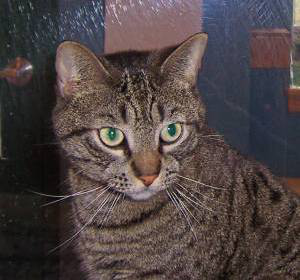

In [22]:
from PIL import Image
Image.open('data/cats_dogs_dataset/training_set/training_set/cats/cat.1.jpg')

## 数据集目录结构

In [21]:
'''
data/cats_dogs_dataset
├── classes.txt
├── test.txt
├── val.txt
├── training_set
│   ├── training_set
│   │   ├── cats
│   │   │   ├── cat.1.jpg
│   │   │   ├── cat.2.jpg
│   │   │   ├── ...
│   │   ├── dogs
│   │   │   ├── dog.2.jpg
│   │   │   ├── dog.3.jpg
│   │   │   ├── ...
├── val_set
│   ├── val_set
│   │   ├── cats
│   │   │   ├── cat.3.jpg
│   │   │   ├── cat.5.jpg
│   │   │   ├── ...
│   │   ├── dogs
│   │   │   ├── dog.1.jpg
│   │   │   ├── dog.6.jpg
│   │   │   ├── ...
├── test_set
│   ├── test_set
│   │   ├── cats
│   │   │   ├── cat.4001.jpg
│   │   │   ├── cat.4002.jpg
│   │   │   ├── ...
│   │   ├── dogs
│   │   │   ├── dog.4001.jpg
│   │   │   ├── dog.4002.jpg
│   │   │   ├── ...
'''

## 创建 config 配置文件

In [30]:
'''
Model config, which specify the basic structure of the model, e.g. number of the input channels.
Dataset config, which contains details about the dataset, e.g. type of the dataset.
Schedule config, which specify the training schedules, e.g. learning rate.
Runtime config, which contains the rest of details, e.g. log config.
'''

In [ ]:
# Load the existing config file
from mmcv import Config
cfg = Config.fromfile('configs/mobilenet_v2/mobilenet_v2_b32x8_imagenet.py')

In [ ]:
# Modify num classes of the model in classification head
cfg.model.head.num_classes = 2
cfg.model.head.topk = (1, )

In [ ]:
# Modify the number of workers according to your computer
cfg.data.samples_per_gpu = 32
cfg.data.workers_per_gpu = 2

# Specify the path to training set
cfg.data.train.data_prefix = 'data/cats_dogs_dataset/training_set/training_set'
cfg.data.train.classes = 'data/cats_dogs_dataset/classes.txt'
# Specify the path to validation set
cfg.data.val.data_prefix = 'data/cats_dogs_dataset/val_set/val_set'
cfg.data.val.ann_file = 'data/cats_dogs_dataset/val.txt'
cfg.data.val.classes = 'data/cats_dogs_dataset/classes.txt'
# Specify the path to test set
cfg.data.test.data_prefix = 'data/cats_dogs_dataset/test_set/test_set'
cfg.data.test.ann_file = 'data/cats_dogs_dataset/test.txt'
cfg.data.test.classes = 'data/cats_dogs_dataset/classes.txt'

# Modify the metric method
cfg.evaluation['metric_options']={'topk': (1, )}

In [ ]:
# Optimizer
cfg.optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# Learning policy
cfg.lr_config = dict(policy='step', step=[1])
cfg.runner = dict(type='EpochBasedRunner', max_epochs=2)

In [17]:
# Load the pretrained weights
cfg.load_from = 'checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth'
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/cats_dogs_dataset'

from mmcls.apis import set_random_seed
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)

cfg.gpu_ids = range(1)

In [ ]:
# Let's have a look at the final config used for finetuning
print(f'Config:\n{cfg.pretty_text}')

In [18]:
import time
import mmcv
import os.path as osp

from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.apis import train_model

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# Build the classifier
model = build_classifier(cfg.model)
# Build the dataset
datasets = [build_dataset(cfg.data.train)]
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
# Begin finetuning
train_model(
    model,
    datasets,
    cfg,
    distributed=False,
    validate=True,
    timestamp=time.strftime('%Y%m%d_%H%M%S', time.localtime()),
    meta=dict())

2022-07-16 19:35:50,711 - mmcls - INFO - load checkpoint from local path: checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth
2022-07-16 19:35:50,741 - mmcls - WARNING - The model and loaded state dict do not match exactly

size mismatch for head.fc.weight: copying a param with shape torch.Size([1000, 1280]) from checkpoint, the shape in current model is torch.Size([2, 1280]).
size mismatch for head.fc.bias: copying a param with shape torch.Size([1000]) from checkpoint, the shape in current model is torch.Size([2]).
2022-07-16 19:35:50,743 - mmcls - INFO - Start running, host: featurize@featurize, work_dir: /home/featurize/work/MMClassification教程/mmclassification/work_dirs/cats_dogs_dataset
2022-07-16 19:35:50,743 - mmcls - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook     

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1601/1601, 335.8 task/s, elapsed: 5s, ETA:     0s

2022-07-16 19:36:17,388 - mmcls - INFO - Epoch(val) [1][51]	accuracy_top-1: 91.8176
2022-07-16 19:36:29,114 - mmcls - INFO - Epoch [2][100/201]	lr: 1.000e-03, eta: 0:00:11, time: 0.117, data_time: 0.057, memory: 2456, loss: 0.2605
2022-07-16 19:36:38,628 - mmcls - INFO - Epoch [2][200/201]	lr: 1.000e-03, eta: 0:00:00, time: 0.095, data_time: 0.033, memory: 2456, loss: 0.2385
2022-07-16 19:36:38,675 - mmcls - INFO - Saving checkpoint at 2 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1601/1601, 321.0 task/s, elapsed: 5s, ETA:     0s

2022-07-16 19:36:43,765 - mmcls - INFO - Epoch(val) [2][51]	accuracy_top-1: 95.2530


## 用训练得到的图像分类模型，对新图像预测

类别 cats 置信度 0.9999997615814209


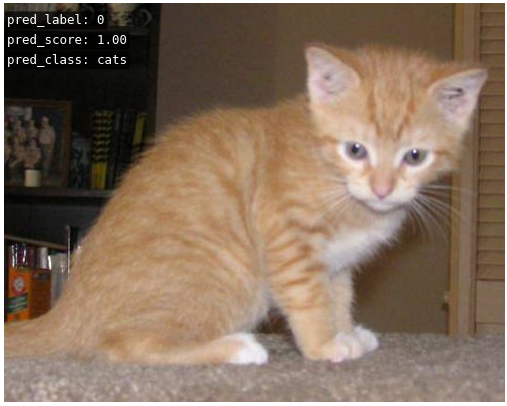

In [50]:
import matplotlib.pyplot as plt

img = mmcv.imread('data/cats_dogs_dataset/test_set/test_set/cats/cat.4003.jpg')
# img = mmcv.imread('data/cat2.jpg')

model.cfg = cfg
result = inference_model(model, img)
print('类别', result['pred_class'], '置信度', result['pred_score'])

show_result_pyplot(model, img, result)

## 命令行-训练

In [52]:
# 下载预先写好的 config 配置文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/configs/mobilenet_v2_1x_cats_dogs.py -O configs/mobilenet_v2/mobilenet_v2_1x_cats_dogs.py


--2022-07-16 22:18:48--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/configs/mobilenet_v2_1x_cats_dogs.py
Connecting to 172.16.0.13:5848... connected.
Proxy request sent, awaiting response... 200 OK
Length: 2046 (2.0K) [binary/octet-stream]
Saving to: ‘configs/mobilenet_v2/mobilenet_v2_1x_cats_dogs.py’

configs/mobilenet_v 100%[===================>]   2.00K  --.-KB/s    in 0s      

2022-07-16 22:18:48 (12.2 MB/s) - ‘configs/mobilenet_v2/mobilenet_v2_1x_cats_dogs.py’ saved [2046/2046]



In [25]:
!python tools/train.py \
        configs/mobilenet_v2/mobilenet_v2_1x_cats_dogs.py \
        --work-dir work_dirs/mobilenet_v2_1x_cats_dogs

/home/featurize/work/MMClassification教程/mmclassification/mmcls/utils/setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/home/featurize/work/MMClassification教程/mmclassification/mmcls/utils/setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
2022-07-16 21:52:13,919 - mmcls - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.10 (default, Jun  4 2021, 14:48:32) [GCC 7.5.0]
CUDA available: True
GPU 0: NVIDIA RTX A4000
CUD

## 将训练得到的模型在测试集上预测，获得所有测试集数据的预测结果

In [26]:
!python tools/test.py \
        configs/mobilenet_v2/mobilenet_v2_1x_cats_dogs.py \
        work_dirs/mobilenet_v2_1x_cats_dogs/latest.pth \
        --out results.json

/home/featurize/work/MMClassification教程/mmclassification/mmcls/utils/setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/home/featurize/work/MMClassification教程/mmclassification/mmcls/utils/setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
load checkpoint from local path: work_dirs/mobilenet_v2_1x_cats_dogs/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2023/2023, 356.0 task/s, elapsed: 6s, ETA:     0s
dumping results to results.json


## 将训练得到的模型在测试集上预测，获得图像分类评估结果

In [28]:
!python tools/test.py \
        configs/mobilenet_v2/mobilenet_v2_1x_cats_dogs.py \
        work_dirs/mobilenet_v2_1x_cats_dogs/latest.pth \
        --metrics accuracy precision recall f1_score support \
        --metric-options topk=1


/home/featurize/work/MMClassification教程/mmclassification/mmcls/utils/setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/home/featurize/work/MMClassification教程/mmclassification/mmcls/utils/setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
load checkpoint from local path: work_dirs/mobilenet_v2_1x_cats_dogs/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 2023/2023, 354.1 task/s, elapsed: 6s, ETA:     0s
accuracy : 91.35

support : 2023.0

precision : 91.8

recall : 91.35

f1_score : 91.33
